# LATENT SPACE DOMAIN EXPLORATION

## Libraries

In [1]:
import os, random
import glob
import sys
import cv2
import torch
import torchvision
import numpy as np
import pandas as pd
import office31
from sklearn.manifold import TSNE
from mpl_toolkits.axes_grid1 import ImageGrid



import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
from collections import defaultdict 
from PIL import Image


from matplotlib.image import imread
from tqdm import tqdm_notebook as tqdm

# Load Model from SharkDetectorProject Repository
model_dir = '/home/user/Documents/MADA-PL/Models/'
experiment_path = "/home/user/Documents/Experiments/"
os.chdir(model_dir)
sys.path.append(model_dir)

from run import Runner
from tools.utils import get_transform
from tools.MNISTM import MNISTM

## Loading Models

In [2]:
# DOMAIN 
run_DANN = Runner(mode='Inference', 
            configfile_path="/home/user/Documents/Experiments/DANN_MNIST_1628561779/Models/config_DANN.yml",
            ckpt_path='/home/user/Documents/Experiments/DANN_MNIST_1628561779/DANN_MNIST_1628561779_epoch26-val_loss_src_step0.05.ckpt')

run_DCNN = Runner(mode='Inference', 
            configfile_path="/home/user/Documents/Experiments/DCNN_MNIST_1628566858/Models/config_DCNN.yml",
            ckpt_path='/home/user/Documents/Experiments/DCNN_MNIST_1628566858/DCNN_MNIST_1628566858_epoch00-val_loss_src_step0.04.ckpt')

run_MADA = Runner(mode='Inference', 
            configfile_path="/home/user/Documents/Experiments/MADA_MNIST_1628573386/Models/config_MADA.yml",
            ckpt_path='/home/user/Documents/Experiments/MADA_MNIST_1628573386/MADA_MNIST_1628573386_epoch14-val_loss_src_step0.44.ckpt')


Load resnet34, pretrained weights : imagenet
Load resnet34, pretrained weights : imagenet
backbone_fixed.0.weight True
backbone_fixed.1.weight True
backbone_fixed.1.bias True
backbone_fixed.4.0.conv1.weight True
backbone_fixed.4.0.bn1.weight True
backbone_fixed.4.0.bn1.bias True
backbone_fixed.4.0.conv2.weight True
backbone_fixed.4.0.bn2.weight True
backbone_fixed.4.0.bn2.bias True
backbone_fixed.4.1.conv1.weight True
backbone_fixed.4.1.bn1.weight True
backbone_fixed.4.1.bn1.bias True
backbone_fixed.4.1.conv2.weight True
backbone_fixed.4.1.bn2.weight True
backbone_fixed.4.1.bn2.bias True
backbone_fixed.4.2.conv1.weight True
backbone_fixed.4.2.bn1.weight True
backbone_fixed.4.2.bn1.bias True
backbone_fixed.4.2.conv2.weight True
backbone_fixed.4.2.bn2.weight True
backbone_fixed.4.2.bn2.bias True
backbone_fixed.5.0.conv1.weight True
backbone_fixed.5.0.bn1.weight True
backbone_fixed.5.0.bn1.bias True
backbone_fixed.5.0.conv2.weight True
backbone_fixed.5.0.bn2.weight True
backbone_fixed.5.0

Load resnet18, pretrained weights : imagenet
backbone_fixed.0.weight True
backbone_fixed.1.weight True
backbone_fixed.1.bias True
backbone_fixed.4.0.conv1.weight True
backbone_fixed.4.0.bn1.weight True
backbone_fixed.4.0.bn1.bias True
backbone_fixed.4.0.conv2.weight True
backbone_fixed.4.0.bn2.weight True
backbone_fixed.4.0.bn2.bias True
backbone_fixed.4.1.conv1.weight True
backbone_fixed.4.1.bn1.weight True
backbone_fixed.4.1.bn1.bias True
backbone_fixed.4.1.conv2.weight True
backbone_fixed.4.1.bn2.weight True
backbone_fixed.4.1.bn2.bias True
backbone_fixed.5.0.conv1.weight True
backbone_fixed.5.0.bn1.weight True
backbone_fixed.5.0.bn1.bias True
backbone_fixed.5.0.conv2.weight True
backbone_fixed.5.0.bn2.weight True
backbone_fixed.5.0.bn2.bias True
backbone_fixed.5.0.downsample.0.weight True
backbone_fixed.5.0.downsample.1.weight True
backbone_fixed.5.0.downsample.1.bias True
backbone_fixed.5.1.conv1.weight True
backbone_fixed.5.1.bn1.weight True
backbone_fixed.5.1.bn1.bias True
backb

## Loading MNIST and MNISTM Test datasets

In [3]:
test_set_mnist = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST(
                        root=experiment_path, 
                        train=False, 
                        download=True, 
                        transform=get_transform(run_DANN.transformation, "src")
                    ),
                    batch_size=256, 
                    shuffle=True)

test_set_mnistm = torch.utils.data.DataLoader(
                    MNISTM(
                        root=experiment_path, 
                        train=False, 
                        download=True,
                        transform=get_transform(run_DANN.transformation, "tgt")
                    ),
                    batch_size=256, 
                    shuffle=True)

## Extracting the MNIST Features

In [5]:
mmist_backbone = []
mnist_features = []
mnist_features_invariant_DANN = []
mnist_features_invariant_MADA = []


# for each batch in test_set_mnist
for i, (images, labels) in enumerate(iter(test_set_mnist)):
    features_backbone, features_DCNN  = run_DCNN.net.extract_features(images.cuda())
    _, features_invariant_DANN  = run_DANN.net.extract_features(images.cuda())
    _, features_invariant_MADA  = run_MADA.net.extract_features(images.cuda())


    features_backbone = features_backbone.cpu().detach().numpy()
    features_DCNN = features_DCNN.cpu().detach().numpy()
    features_invariant_DANN = features_invariant_DANN.cpu().detach().numpy()
    features_invariant_MADA = features_invariant_MADA.cpu().detach().numpy()
    
    # for each element in the batch
    for i in range(len(features_backbone)):
        mmist_backbone.append(features_backbone[i])
        mnist_features.append(features_DCNN[i])
        mnist_features_invariant_DANN.append(features_invariant_DANN[i])
        mnist_features_invariant_MADA.append(features_invariant_MADA[i])


## Extracting the MNISTM Features

In [6]:
mmistm_backbone = []
mnistm_features = []
mnistm_features_invariant_DANN = []
mnistm_features_invariant_MADA = []

# for each batch in test_set_mnistm
for i, (images, labels) in enumerate(iter(test_set_mnistm)):
    features_backbone, features_DCNN  = run_DCNN.net.extract_features(images.cuda())
    _, features_invariant_DANN  = run_DANN.net.extract_features(images.cuda())
    _, features_invariant_MADA  = run_MADA.net.extract_features(images.cuda())


    features_backbone = features_backbone.cpu().detach().numpy()
    features_DCNN = features_DCNN.cpu().detach().numpy()
    features_invariant_DANN = features_invariant_DANN.cpu().detach().numpy()
    features_invariant_MADA = features_invariant_MADA.cpu().detach().numpy()

    # for each element in the batch
    for i in range(len(features_backbone)):
        mmistm_backbone.append(features_backbone[i])
        mnistm_features.append(features_DCNN[i])
        mnistm_features_invariant_DANN.append(features_invariant_DANN[i])
        mnistm_features_invariant_MADA.append(features_invariant_MADA[i])

## APPLY TSNE to map datapoints to 3D space

In [7]:
tsne = TSNE(n_components=3, init='pca', perplexity=25, n_iter=1000, learning_rate=10)

mnist_backbone_features_3D = tsne.fit_transform(mmist_backbone[:1000])
mnistm_backbone_features_3D = tsne.fit_transform(mmistm_backbone[:1000])

mnist_features_3D = tsne.fit_transform(mnist_features[:1000])
mnistm_features_3D = tsne.fit_transform(mnistm_features[:1000])

mnist_features_invariant_DANN_3D = tsne.fit_transform(mnist_features_invariant_DANN[:1000])
mnistm_features_invariant_DANN_3D = tsne.fit_transform(mnistm_features_invariant_DANN[:1000])

mnist_features_invariant_MADA_3D = tsne.fit_transform(mnist_features_invariant_MADA[:1000])
mnistm_features_invariant_MADA_3D = tsne.fit_transform(mnistm_features_invariant_MADA[:1000])

mnist__mnistm_backbone_features_3D = np.concatenate((mnist_backbone_features_3D, mnistm_backbone_features_3D), 0)
mnist__mnistm_features_3D = np.concatenate((mnist_features_3D, mnistm_features_3D), 0)
mnist__mnistm_features_invariant_DANN_3D = np.concatenate((mnist_features_invariant_DANN_3D, mnistm_features_invariant_DANN_3D), 0)
mnist__mnistm_features_invariant_MADA_3D = np.concatenate((mnist_features_invariant_MADA_3D, mnistm_features_invariant_MADA_3D), 0)

domain_colors = ['b' for _ in range(len(mnist_features_3D))] + ['r' for _ in range(len(mnistm_features_3D))]

## Pretrained RESNET (Not retrained) Domain Distribution

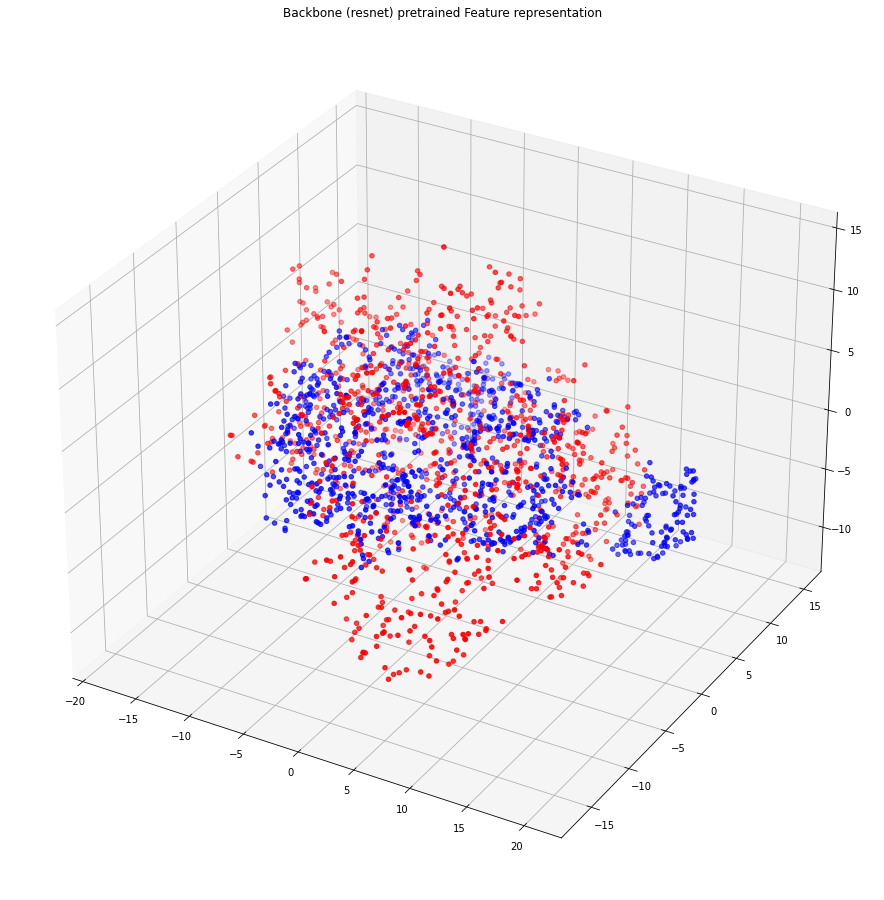

In [8]:
fig = plt.figure(figsize=(16,16))
ax = fig.gca(projection='3d')
plt.title('Backbone (resnet) pretrained Feature representation')
ax.scatter3D(mnist__mnistm_backbone_features_3D[:, 0], mnist__mnistm_backbone_features_3D[:, 1], mnist__mnistm_backbone_features_3D[:, 2], c = domain_colors)
plt.savefig('/home/user/Documents/MADA-PL/Notebooks/Backbone_pretrained_Feature_representation.png')
plt.show()


##  DCNN (Trained only on Source) Domain Distribution

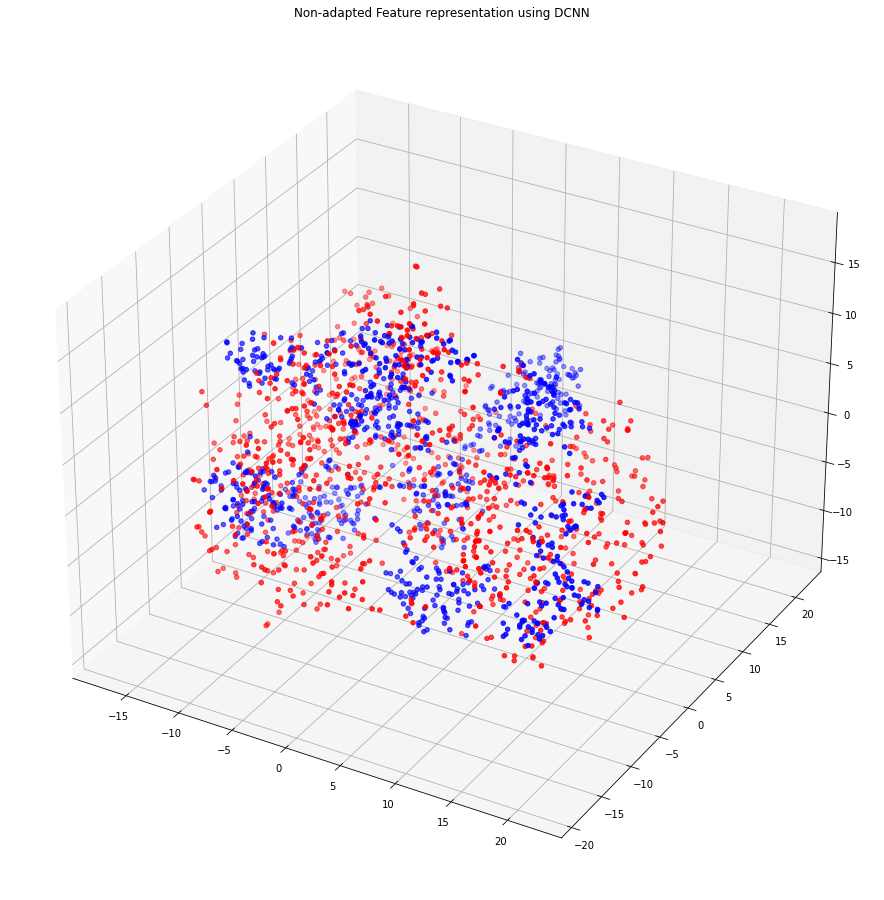

In [9]:
fig = plt.figure(figsize=(16,16))
ax = fig.gca(projection='3d')
plt.title('Non-adapted Feature representation using DCNN')
ax.scatter3D(mnist__mnistm_features_3D[:, 0], mnist__mnistm_features_3D[:, 1], mnist__mnistm_features_3D[:, 2], c = domain_colors)
plt.savefig('/home/user/Documents/MADA-PL/Notebooks/DCNN_Feature_representation.png')
plt.show()

## DANN (Trained using GRL) Domain Distribution

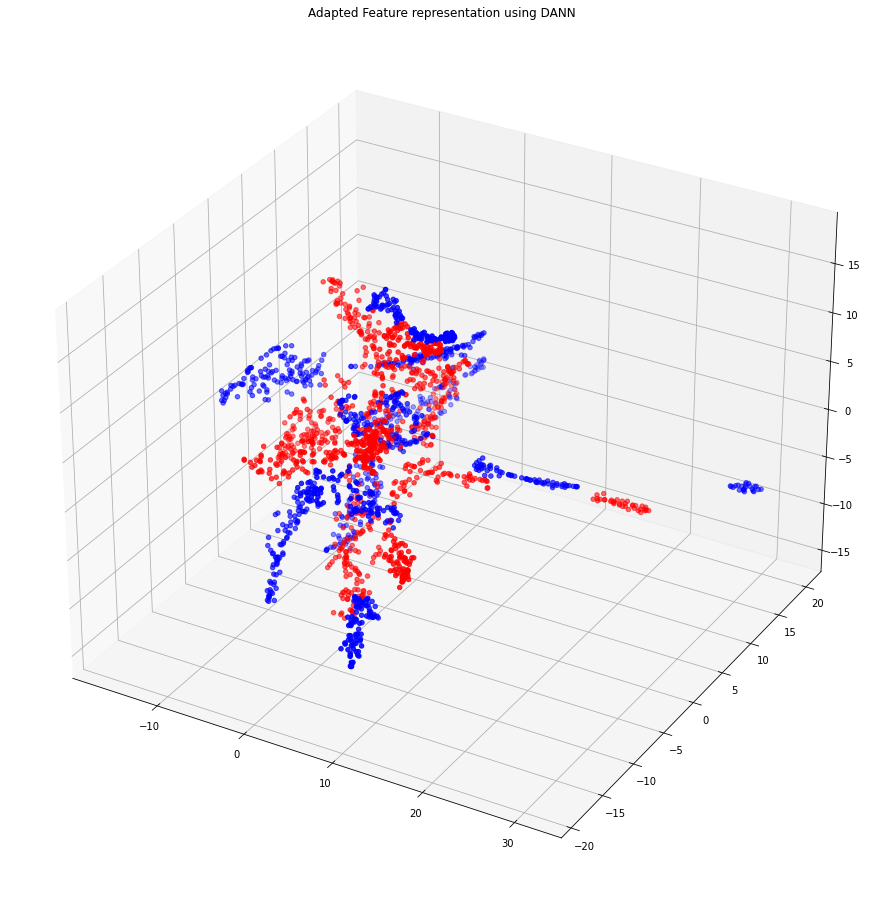

In [10]:
fig = plt.figure(figsize=(16,16))
ax = fig.gca(projection='3d')
plt.title('Adapted Feature representation using DANN')
scatter = ax.scatter3D(mnist__mnistm_features_invariant_DANN_3D[:, 0], mnist__mnistm_features_invariant_DANN_3D[:, 1], mnist__mnistm_features_invariant_DANN_3D[:, 2], c = domain_colors)
plt.savefig('/home/user/Documents/MADA-PL/Notebooks/DANN_Feature_representation.png')
plt.show()


## MADA (Trained using GRL, class-wise) Domain Distribution

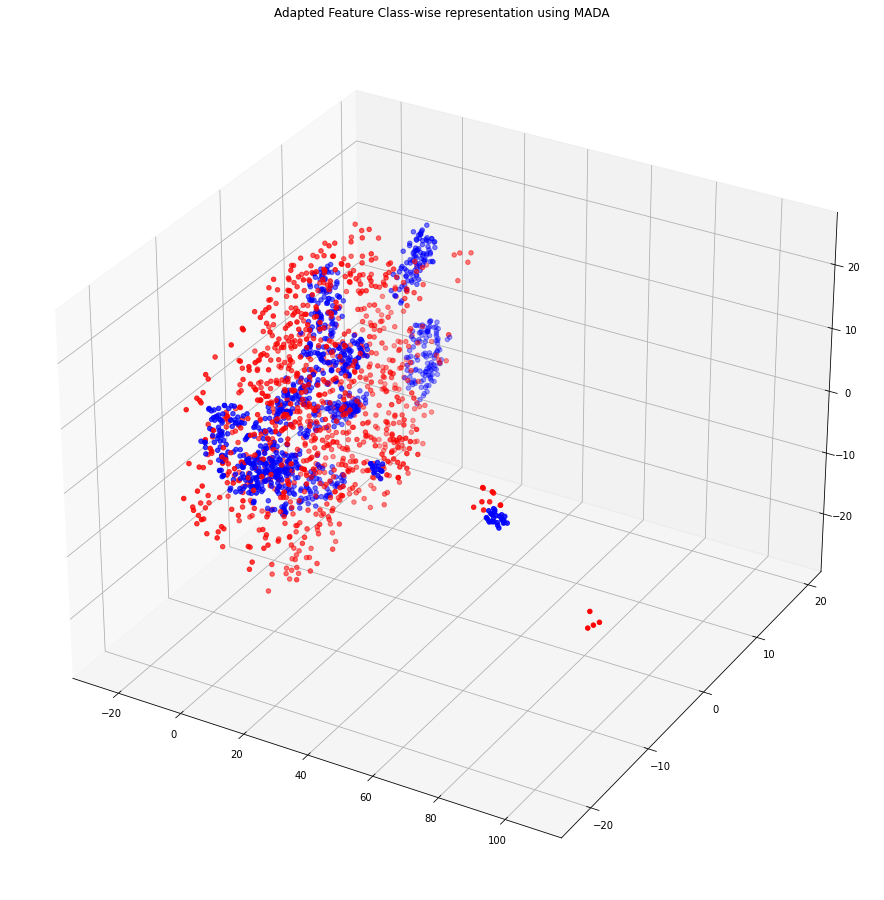

In [11]:
fig = plt.figure(figsize=(16,16))
ax = fig.gca(projection='3d')
plt.title('Adapted Feature Class-wise representation using MADA')
scatter = ax.scatter3D(mnist__mnistm_features_invariant_MADA_3D[:, 0], mnist__mnistm_features_invariant_MADA_3D[:, 1], mnist__mnistm_features_invariant_MADA_3D[:, 2], c = domain_colors)
plt.savefig('/home/user/Documents/MADA-PL/Notebooks/MADA_Feature_representation.png')
plt.show()
